In [1]:
import numpy as np

import os

from nbodykit.lab import *
from nbodykit import setup_logging, style

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import SymLogNorm

/home/jamesdr/.conda/envs/usrp2024/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from baryonification.baryonification.params import par
from baryonification.baryonification.cosmo import cosmo
from baryonification.baryonification.displ import displace
from baryonification.baryonification.halo_displ import displace_haloes

from miniramses.utils.py.miniramses import rd_info
from miniramses.utils.py.miniramses import Info

In [3]:
#initialise parameters
par = par()
par.files.transfct = "/home/jamesdr/usrp2024/baryonification/baryonification/files/CDM_PLANCK_tk.dat"
par.files.cosmofct = "/home/jamesdr/usrp2024/baryonification/baryonification/files/cosmofct.dat"
par.files.displfct = "/home/jamesdr/usrp2024/baryonification/baryonification/files/displfct.dat"
par.files.halofile_format = "ramses"
par.files.partfile_format = "ramses"
par.files.partfile_in = "/home/jamesdr/scratch/miniramses/output_00011"
par.files.partfile_out = "/home/jamesdr/usrp2024/partfile_out.std"
par.files.halofile_in = "/home/jamesdr/scratch/miniramses/output_00011"
par.files.halofile_out = "/home/jamesdr/usrp2024/halofile_out.std"

Found 134217728 particles
Reading particle data...


In [4]:
import re

# Extracting the path using regular expression
path = re.match(r'(.*/miniramses/)', par.files.partfile_in).group(1)

# Extracting the number as an integer
nout = int(re.match(r'.*/output_(\d+)', par.files.partfile_in).group(1))

i = rd_info(nout, path=path)
unit_l = i.unit_l
unit_d = i.unit_d #g/cm^3
unit_m = unit_d * (unit_l)**3.0
unit_m_in_Msol_per_h = unit_m / (1.989e33) * par.cosmo.h0
unit_l_in_Mpc_per_h = unit_l / (3.086e24) * par.cosmo.h0

In [5]:
from baryonification.baryonification.io import read_nbody_file

In [6]:
p_header, non_displaced_particles = read_nbody_file(par)

Found 134217728 particles
Reading particle data...


In [7]:
cosmo(par);

Normalizing power-spectrum done!


In [8]:
displace(par);

Found 134217728 particles
Reading particle data...
N_cpu =  1
building tree..
...done!
Nhalo_chunk =  55938
Om =  0.27569792
Total number of star particles 5948646


In [9]:
def read_displaced_particles(file):

    Lbox   = unit_l / (3.086e24) * par.cosmo.h0
    N_chunk = 1
    L_chunk = Lbox/N_chunk
    
    Om = i.omega_m
    z  = par.cosmo.z
    
    f = open(file, 'r')

    #header
    p_header_dt = np.dtype([('a','>d'),('Npart','>i'),('dim','>i'),('Ngas','>i'),('Ndm','>i'),('Nstar','>i'),('buffer','>i')])
    p_header = np.fromfile(f, dtype=p_header_dt, count=1, sep='')
    
    #gas
    p_gas_dt = np.dtype([('mass','>f4'),('x', '>f4'),('y', '>f4'),('z', '>f4'),('vx', '>f4'),('vy', '>f4'),\
                               ('vz', '>f4'),('rho','>f4'),('temp','>f4'),('hsmooth','>f4'),('metals','>f4'),('phi','>f4')])
    p_gas = np.fromfile(f, dtype=p_gas_dt, count=int(p_header['Ngas']), sep='')
    
    #dm
    p_dm_dt   = np.dtype([('mass','>f4'),("x",'>f4'),("y",'>f4'),("z",'>f4'),("vx",'>f4'),("vy",'>f4'),("vz",'>f4'),\
                                ("eps",'>f4'),("phi",'>f4')])
    p_dm = np.fromfile(f, dtype=p_dm_dt, count=int(p_header['Ndm']), sep='')
    
    #stars
    p_star_dt = np.dtype([('mass','>f4'),('x', '>f4'),('y', '>f4'),('z', '>f4'),('vx', '>f4'),('vy', '>f4'),\
                                 ('vz', '>f4'),('metals','>f4'),('tform','>f4'),('eps','>f4'),('phi','>f4')])
    p_star = np.fromfile(f, dtype=p_star_dt, count=int(p_header['Nstar']), sep='')

    #convert to Mpc/h
    p_gas['x']=Lbox*(p_gas['x']+0.5)
    p_gas['y']=Lbox*(p_gas['y']+0.5)
    p_gas['z']=Lbox*(p_gas['z']+0.5)
    p_dm['x']=Lbox*(p_dm['x']+0.5)
    p_dm['y']=Lbox*(p_dm['y']+0.5)
    p_dm['z']=Lbox*(p_dm['z']+0.5)
    p_star['x']=Lbox*(p_star['x']+0.5)
    p_star['y']=Lbox*(p_star['y']+0.5)
    p_star['z']=Lbox*(p_star['z']+0.5)

    #convert to Mstar/h
    print("Om = ", np.sum(p_gas['mass'])+np.sum(p_dm['mass'])+np.sum(p_star['mass']))
    p_gas['mass'] = p_gas['mass'] * 2.776e11*(Om*(1.0+z)**3.0 + (1.0-Om))/(1.0+z)**3.0 *Lbox**3
    p_dm['mass'] = p_dm['mass'] * 2.776e11*(Om*(1.0+z)**3.0 + (1.0-Om))/(1.0+z)**3.0 *Lbox**3
    p_star['mass'] = p_star['mass'] * 2.776e11*(Om*(1.0+z)**3.0 + (1.0-Om))/(1.0+z)**3.0 *Lbox**3
        
    print('Reading tipsy-file done!')
    
    #split particles into chunks
    p_gas_list   = []
    for x_min in np.linspace(0,Lbox-L_chunk,N_chunk):
        x_max = x_min + L_chunk
        if (x_max == Lbox):
            x_max = 1.00001*x_max
        for y_min in np.linspace(0,Lbox-L_chunk,N_chunk):
            y_max =y_min + L_chunk
            if (y_max == Lbox):
                    y_max = 1.00001*y_max
            for z_min in np.linspace(0,Lbox-L_chunk,N_chunk):
                z_max = z_min + L_chunk
                if (z_max == Lbox):
                        z_max = 1.00001*z_max
                ID_gas = np.where((p_gas['x']>=x_min) & (p_gas['x']<x_max) & (p_gas['y']>=y_min) & (p_gas['y']<y_max) & (p_gas['z']>=z_min) & (p_gas['z']<z_max))
                p_gas_list += [p_gas[ID_gas]]
                
    #split particles into chunks
    p_dm_list   = []
    for x_min in np.linspace(0,Lbox-L_chunk,N_chunk):
        x_max = x_min + L_chunk
        if (x_max == Lbox):
            x_max = 1.00001*x_max
        for y_min in np.linspace(0,Lbox-L_chunk,N_chunk):
            y_max =y_min + L_chunk
            if (y_max == Lbox):
                    y_max = 1.00001*y_max
            for z_min in np.linspace(0,Lbox-L_chunk,N_chunk):
                z_max = z_min + L_chunk
                if (z_max == Lbox):
                        z_max = 1.00001*z_max
                ID_dm = np.where((p_dm['x']>=x_min) & (p_dm['x']<x_max) & (p_dm['y']>=y_min) & (p_dm['y']<y_max) & (p_dm['z']>=z_min) & (p_dm['z']<z_max))
                p_dm_list += [p_dm[ID_dm]]
                
    #split particles into chunks
    p_star_list   = []
    for x_min in np.linspace(0,Lbox-L_chunk,N_chunk):
        x_max = x_min + L_chunk
        if (x_max == Lbox):
            x_max = 1.00001*x_max
        for y_min in np.linspace(0,Lbox-L_chunk,N_chunk):
            y_max =y_min + L_chunk
            if (y_max == Lbox):
                    y_max = 1.00001*y_max
            for z_min in np.linspace(0,Lbox-L_chunk,N_chunk):
                z_max = z_min + L_chunk
                if (z_max == Lbox):
                        z_max = 1.00001*z_max
                ID_star = np.where((p_star['x']>=x_min) & (p_star['x']<x_max) & (p_star['y']>=y_min) & (p_star['y']<y_max) & (p_star['z']>=z_min) & (p_star['z']<z_max))
                p_star_list += [p_star[ID_star]]
    
    return p_header, p_gas_list, p_dm_list, p_star_list

In [10]:
p_displaced_header, displaced_gas, displaced_dm, displaced_stars = read_displaced_particles("/home/jamesdr/usrp2024/partfile_out.std")

Om =  0.27569792
Reading tipsy-file done!


In [11]:
plt.style.use(style.notebook)
setup_logging()

In [12]:
DMO = ArrayCatalog({'Position' : np.vstack((non_displaced_particles[0]['x'],non_displaced_particles[0]['y'],non_displaced_particles[0]['z'])).T})

DM = ArrayCatalog({'Position' : np.vstack((displaced_dm[0]['x'],displaced_dm[0]['y'],displaced_dm[0]['z'])).T})
gas = ArrayCatalog({'Position' : np.vstack((displaced_gas[0]['x'],displaced_gas[0]['y'],displaced_gas[0]['z'])).T})
star = ArrayCatalog({'Position' : np.vstack((displaced_stars[0]['x'],displaced_stars[0]['y'],displaced_stars[0]['z'])).T})

DMO['Mass'] = 1.0
DM['Mass'] = displaced_dm[0]['mass'][0]/(displaced_dm[0]['mass'][0] + displaced_gas[0]['mass'][0] + displaced_stars[0]['mass'][0])
gas['Mass'] = displaced_gas[0]['mass'][0]/(displaced_dm[0]['mass'][0] + displaced_gas[0]['mass'][0] + displaced_stars[0]['mass'][0])
star['Mass'] = displaced_stars[0]['mass'][0]/(displaced_dm[0]['mass'][0] + displaced_gas[0]['mass'][0] + displaced_stars[0]['mass'][0])

m_DMO = DMO['Mass']
m_DM = DM['Mass']
m_gas = gas['Mass']
m_star = star['Mass']

combined = MultipleSpeciesCatalog(['DM', 'gas', 'star'], DM, gas, star)

In [13]:
DMO_mesh = DMO.to_mesh(resampler='tsc', Nmesh=2048, BoxSize=unit_l_in_Mpc_per_h, compensated=True, position='Position', weight='Mass')

DM_mesh = DM.to_mesh(resampler='tsc', Nmesh=2048, BoxSize=unit_l_in_Mpc_per_h, compensated=True, position='Position', weight='Mass')
gas_mesh = gas.to_mesh(resampler='tsc', Nmesh=2048, BoxSize=unit_l_in_Mpc_per_h, compensated=True, position='Position', weight='Mass')
star_mesh = star.to_mesh(resampler='tsc', Nmesh=2048, BoxSize=unit_l_in_Mpc_per_h, compensated=True, position='Position', weight='Mass')

combined_mesh = combined.to_mesh(resampler='tsc', Nmesh=2048, BoxSize=unit_l_in_Mpc_per_h, compensated=True, position='Position', weight='Mass')

In [14]:
r_DMO = FFTPower(DMO_mesh, mode='1d', dk=0.05, kmin=0.05)

r_DM = FFTPower(DM_mesh, mode='1d', dk=0.05, kmin=0.05)
r_gas = FFTPower(gas_mesh, mode='1d', dk=0.05, kmin=0.05)
r_star = FFTPower(star_mesh, mode='1d', dk=0.05, kmin=0.05)

r_combined = FFTPower(combined_mesh, mode='1d', dk=0.05, kmin=0.05)

[ 000027.09 ]   0: 07-26 14:15  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 134217728 
[ 000030.06 ]   0: 07-26 14:15  CatalogMesh     INFO     painted 4194304 out of 134217728 objects to mesh
[ 000030.06 ]   0: 07-26 14:15  CatalogMesh     INFO     Chunk 4194304 ~ 8388608 / 134217728 
[ 000032.84 ]   0: 07-26 14:15  CatalogMesh     INFO     painted 8388608 out of 134217728 objects to mesh
[ 000032.84 ]   0: 07-26 14:15  CatalogMesh     INFO     Chunk 8388608 ~ 12582912 / 134217728 
[ 000035.62 ]   0: 07-26 14:15  CatalogMesh     INFO     painted 12582912 out of 134217728 objects to mesh
[ 000035.62 ]   0: 07-26 14:15  CatalogMesh     INFO     Chunk 12582912 ~ 16777216 / 134217728 
[ 000038.34 ]   0: 07-26 14:15  CatalogMesh     INFO     painted 16777216 out of 134217728 objects to mesh
[ 000038.34 ]   0: 07-26 14:15  CatalogMesh     INFO     Chunk 16777216 ~ 20971520 / 134217728 
[ 000041.10 ]   0: 07-26 14:15  CatalogMesh     INFO     painted 20971520 out of 134217728 objects to mes

In [15]:
Pk_DMO = r_DMO.power

Pk_DM = r_DM.power
Pk_gas = r_gas.power
Pk_star = r_star.power

Pk_combined = r_combined.power

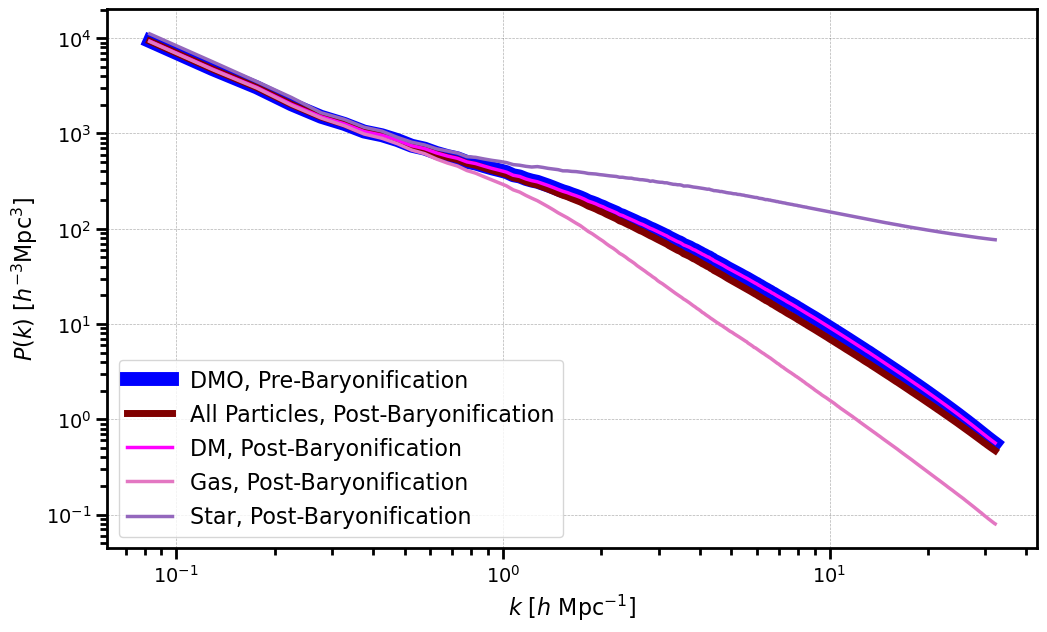

In [19]:
# print the shot noise subtracted P(k)
plt.loglog(Pk_DMO['k'], Pk_DMO['power'].real - Pk_DMO.attrs['shotnoise'], color='blue', linewidth=10.0, label='DMO, Pre-Baryonification')

plt.loglog(Pk_combined['k'], Pk_combined['power'].real - Pk_combined.attrs['shotnoise'], color='maroon', linewidth=5.0, label='All Particles, Post-Baryonification')

plt.loglog(Pk_DM['k'], Pk_DM['power'].real - Pk_DM.attrs['shotnoise'], color='magenta', label='DM, Post-Baryonification')
plt.loglog(Pk_gas['k'], Pk_gas['power'].real - Pk_gas.attrs['shotnoise'], color='tab:pink', label='Gas, Post-Baryonification')
plt.loglog(Pk_star['k'], Pk_star['power'].real - Pk_star.attrs['shotnoise'], color='tab:purple', label='Star, Post-Baryonification')


# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.legend()

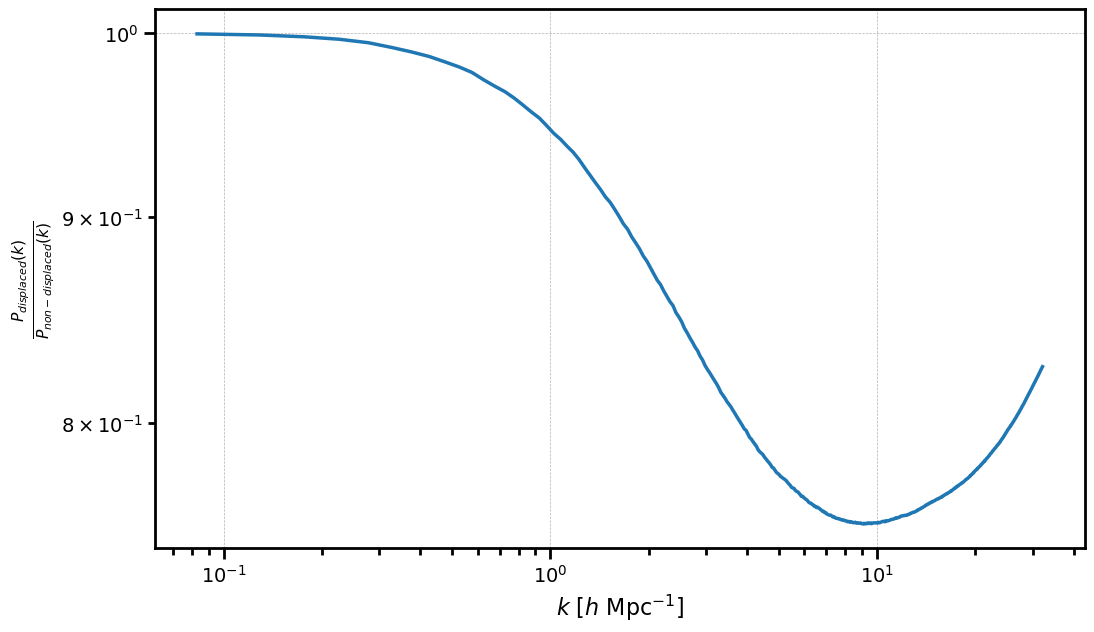

In [17]:
ratio = (Pk_combined['power'].real)/(Pk_DMO['power'].real)
# print the shot noise subtracted P(k)
plt.loglog(Pk_combined['k'], ratio);

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]");
plt.ylabel(r"$\frac{P_{displaced}(k)}{P_{non-displaced}(k)}$");

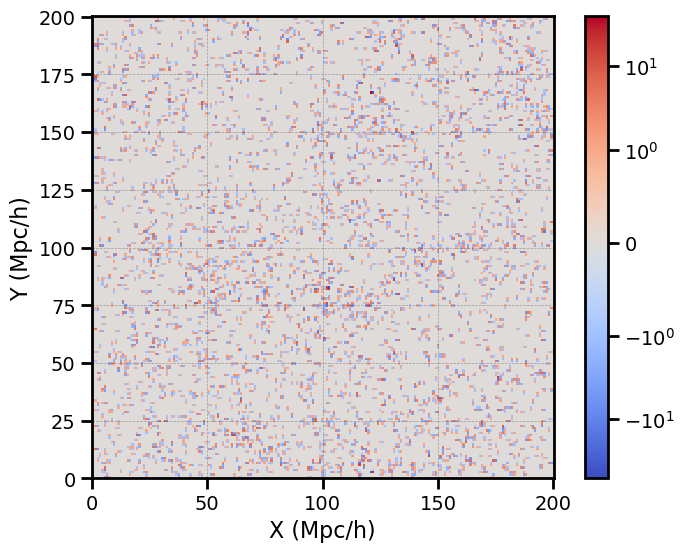

In [18]:
non_displaced_hist, non_displaced_xedges, non_displaced_yedges = np.histogram2d(non_displaced_particles[0]['x'],non_displaced_particles[0]['y'], bins=200)
non_displaced_hist = non_displaced_hist.T

displaced_hist, displaced_xedges, displaced_yedges = np.histogram2d(displaced_dm[0]['x'],displaced_dm[0]['y'], bins=200)
displaced_hist = displaced_hist.T

difference = non_displaced_hist - displaced_hist

norm = SymLogNorm(linthresh=1.0, linscale=1.0, vmin=np.min(difference), vmax=np.max(difference))

# Plotting in log-log scale
plt.figure(figsize=(8, 6))
plt.imshow(difference, interpolation='nearest', origin='lower', extent=[displaced_xedges[0], displaced_xedges[-1], displaced_yedges[0], displaced_yedges[-1]], norm = norm, cmap='coolwarm')

# Add colorbar
plt.colorbar()

# Adding labels and title
plt.xlabel('X (Mpc/h)')
plt.ylabel('Y (Mpc/h)')

plt.show()

In [23]:
import os
np.save(os.path.join('multicomp', 'DMO_k'), Pk_DMO['k'])

np.save(os.path.join('multicomp', 'DM_k'), Pk_DM['k'])
np.save(os.path.join('multicomp', 'gas_k'), Pk_gas['k'])
np.save(os.path.join('multicomp', 'star_k'), Pk_star['k'])

np.save(os.path.join('multicomp', 'combined_k'), Pk_combined['k'])

In [24]:
np.save(os.path.join('multicomp', 'DMO_P'), Pk_DMO['power'])

np.save(os.path.join('multicomp', 'DM_P'), Pk_DM['power'])
np.save(os.path.join('multicomp', 'gas_P'), Pk_gas['power'])
np.save(os.path.join('multicomp', 'star_P'), Pk_star['power'])

np.save(os.path.join('multicomp', 'combined_P'), Pk_combined['power'])

np.save(os.path.join('multicomp', 'ratio'), ratio)